In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor


In [2]:
train_data=datasets.MNIST(root="data",train=True,transform=ToTensor(),
                          download=True)

test_data=datasets.MNIST(root="data",train=False,transform=ToTensor(),
                          download=True)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
train_data.targets.size()

torch.Size([60000])

In [8]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
from torch.utils.data import DataLoader
loaders={
         "train":DataLoader(train_data,batch_size=64,shuffle=True,num_workers=1),
         "test":DataLoader(test_data,batch_size=64,shuffle=True,num_workers=1),
         }


In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(1,10,kernel_size=5)
    self.conv2=nn.Conv2d(10,20,kernel_size=5)
    self.conv2_drop=nn.Dropout2d()
    self.fc1=nn.Linear(320,50)
    self.fc2=nn.Linear(50,10)


  def forward(self,x):
    x=F.relu(F.max_pool2d(self.conv1(x),2))
    x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x=x.view(-1,320)
    x=F.relu(self.fc1(x))
    x=F.dropout(x,training=self.training)
    x=self.fc2(x)

    return F.softmax(x)

In [19]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print(f"Train Epoch {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print(f"\nTest Set: average loss: {test_loss:.4f}, accuracy {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%)\n")


In [20]:
for epoch in range(1,11):
  train(epoch)
  test()

<ipython-input-18-ffdda22ff0ba>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch 1 [0/60000 (0%)]	2.304240
Train Epoch 1 [1280/60000 (2%)]	2.295208
Train Epoch 1 [2560/60000 (4%)]	2.220741
Train Epoch 1 [3840/60000 (6%)]	2.060197
Train Epoch 1 [5120/60000 (9%)]	1.918990
Train Epoch 1 [6400/60000 (11%)]	1.854594
Train Epoch 1 [7680/60000 (13%)]	1.805613
Train Epoch 1 [8960/60000 (15%)]	1.725524
Train Epoch 1 [10240/60000 (17%)]	1.828773
Train Epoch 1 [11520/60000 (19%)]	1.764740
Train Epoch 1 [12800/60000 (21%)]	1.695902
Train Epoch 1 [14080/60000 (23%)]	1.720729
Train Epoch 1 [15360/60000 (26%)]	1.676512
Train Epoch 1 [16640/60000 (28%)]	1.718654
Train Epoch 1 [17920/60000 (30%)]	1.659908
Train Epoch 1 [19200/60000 (32%)]	1.641755
Train Epoch 1 [20480/60000 (34%)]	1.639173
Train Epoch 1 [21760/60000 (36%)]	1.615188
Train Epoch 1 [23040/60000 (38%)]	1.644904
Train Epoch 1 [24320/60000 (41%)]	1.669572
Train Epoch 1 [25600/60000 (43%)]	1.655835
Train Epoch 1 [26880/60000 (45%)]	1.712406
Train Epoch 1 [28160/60000 (47%)]	1.679495
Train Epoch 1 [29440/60000 

Prediction : 0


<ipython-input-18-ffdda22ff0ba>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


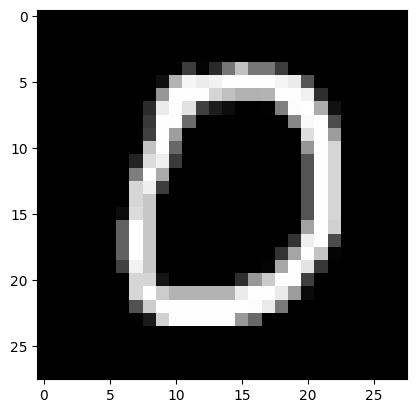

In [24]:
import matplotlib.pyplot as plt
model.eval()
data,target=test_data[10]
data=data.unsqueeze(0).to(device)
output=model(data)
prediction=output.argmax(dim=1,keepdim=True).item()
print(f"Prediction : {prediction}")
image=data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image,cmap="gray")
plt.show()

# Reference
https://youtu.be/vBlO87ZAiiw?si=SGbgmpv8UtJuFsZz